[69.43080634 20.83587384  4.45574212  3.48921397  1.51993984  0.2684239 ]


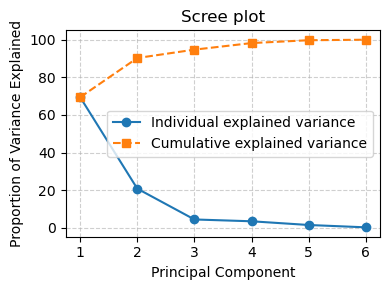

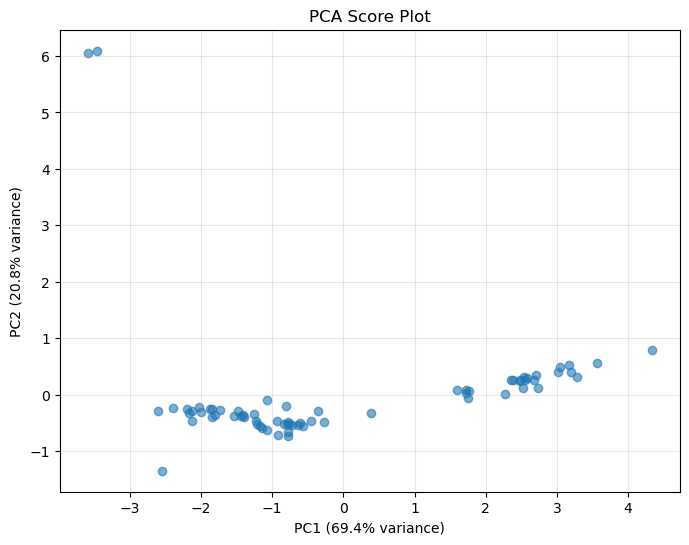

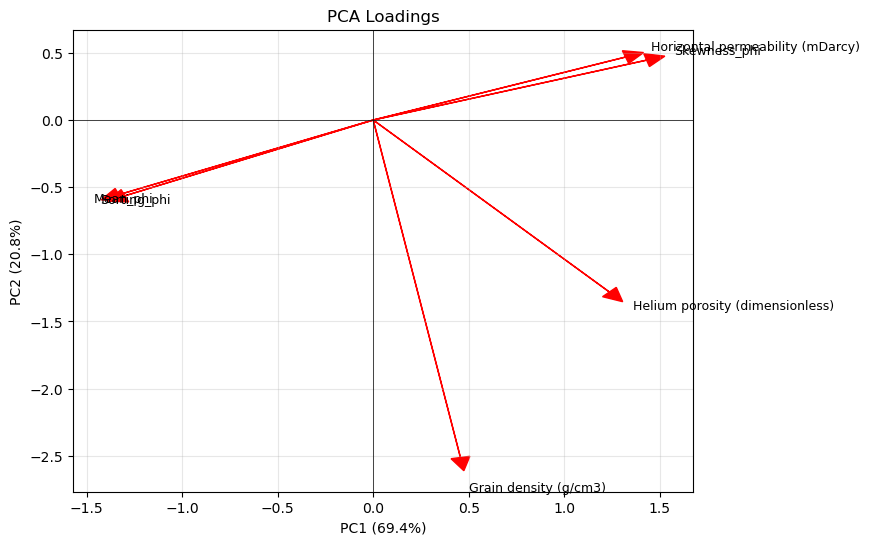

                                       PC1       PC2       PC3       PC4  \
Mean_phi                         -0.444076 -0.185286 -0.671603  0.178871   
Sorting_phi                      -0.433442 -0.188051  0.686520  0.466975   
Skewness_phi                      0.477237  0.148587  0.084399 -0.096501   
Helium porosity (dimensionless)   0.412296 -0.426900  0.147502 -0.134190   
Grain density (g/cm3)             0.152251 -0.837593 -0.102285  0.065001   
Horizontal permeability (mDarcy)  0.440456  0.156274 -0.195699  0.847582   

                                       PC5       PC6  
Mean_phi                          0.221349 -0.486235  
Sorting_phi                       0.033420 -0.293723  
Skewness_phi                     -0.325031 -0.792518  
Helium porosity (dimensionless)   0.771077 -0.115953  
Grain density (g/cm3)            -0.496304  0.119383  
Horizontal permeability (mDarcy)  0.058007  0.146695  


In [112]:
# Perform PCA on grain-size, porosity, and mineral composition data. 
# Plot the first two PCs and discuss what features cluster together — mimicking a "facies vector" type of analysis.
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

file = "TableS1_2.csv"

grain_cols = ['0-2','2-4','4-8','8-16','16-25','25-35','35-50','50-63','63-75','75-88','88-105','105-125','125-150',
              '150-177','177-210','210-250','250-300','300-354','354-420','420-500','500-600','600-707','707-850',
              '850-1000','1000-1190','1190-1410','1410-1680','1680-2000'] # All the columns that represent grain size

df = pd.read_csv(file, header=1) # header=1 skips the 1st row and treats the 2nd like the title for each column
df = df[grain_cols].copy() # keep only for bins for now


# normalize to sum to 1 
df_frac = df.div(df.sum(axis=1), axis=0).fillna(0)

# Define bin midpoints in mm and convert to phi
# columns in micrometers. Convert midpoints to mm for phi calculation
# Provide midpoints (in micrometers) matching bin ranges.

midpoints_um = np.array([1, 3, 6, 12, 20, 30, 42, 56, 69, 80, 96, 115, 138, 163, 193, 230, 
                         275, 327, 387, 460, 550, 650, 780, 925, 1100, 1300, 1550, 1840])

# convert um to mm

midpoints_mm = midpoints_um / 1000

# phi scale: φ = -log2(partical size in mm)
phi_mid = -np.log2(midpoints_mm)

# df_frac: dataframe of just the grain-size fraction columns
W = df_frac.to_numpy()
W = W/W.sum(axis=1, keepdims=True) # normalize to sum to 1 (just in case)

# Step 1: calculate Weighted Mean ("center" of distribution)(keep in phi for plotting; report in mm)
mean_phi = (W * phi_mid).sum(axis=1) # axis=1 just tells calculation to run through rows. axis=0 would be to do calc down columns.

# Step 2: calculate Weighted Variance (standard variation or "spread")(non-linear in mm)
var_phi = (W * (phi_mid - mean_phi[:, None])**2).sum(axis=1)
std_phi = np.sqrt(var_phi)

# Step 3: calculate Weighted skewness (tells us if the distribution leans towards coarse or fine)(DIMENSIONLESS)
skew_phi = (W * (phi_mid - mean_phi[:, None])**3).sum(axis=1) / (std_phi**3)

df_stats = pd.DataFrame({
    "Mean_phi": mean_phi,
    "Sorting_phi": std_phi,
    "Skewness_phi": skew_phi
})

# convert mean grain size from phi back to mm and put back in our table
mean_mm = 2**(-mean_phi)
mean_um = mean_mm * 1000

# now add our df_stats to our original table
df_full = pd.read_csv(file,header=1)
df_combined = pd.concat([df_full,df_stats], axis=1) # remember to add axis=1 so it adds new columns

# verify alignment of concatenate 
df_full.index.equals(df_stats.index)

# select columns used in PCA
cols_for_pca = ['Mean_phi', 'Sorting_phi', 'Skewness_phi', 'Helium porosity (dimensionless)', 'Grain density (g/cm3)', 'Horizontal permeability (mDarcy)']


# Ran into error with NaNs in columns. The below tells me the count of NaNs are in each columns
df_combined[cols_for_pca].isna().sum()
# Check for infinites as well.
np.isinf(df_combined[cols_for_pca]).sum()
#Replace all NaNs with 0s.
df_combined[cols_for_pca] = df_combined[cols_for_pca].fillna(0)
# Check NaNs again to make sure it worked - it did
df_combined[cols_for_pca].isna().sum()

# use sklearn Standar Scaler to standardize all columns in preparation for quality PCA
scaler = StandardScaler()
X_std = scaler.fit_transform(df_combined[cols_for_pca])
# calculate covariance matrix
cov_matrix = np.cov(X_std.T)
# calculate eigenvectors and eigenvalues
eigvals, eigvecs = np.linalg.eig(cov_matrix)

# Sort eigenvalues and their corresponding eigenvectors in descending order
idx = eigvals.argsort()[::-1]
eigvals = eigvals[idx]
eigvecs = eigvecs[:, idx]

# Compute the explained variance by each PC
var_exp = eigvals / np.sum(eigvals)
var_exp = var_exp * 100 # puts variance in percentage
print(var_exp)

# Compute cumulative variance explained
cum_var_exp = np.cumsum(var_exp)
# Make a Scree Plot to visualize variance
plt.figure(figsize=(4,3))
plt.plot(range(1, len(var_exp)+1), var_exp, 'o-', label='Individual explained variance')
plt.plot(range(1, len(cum_var_exp) + 1), cum_var_exp, 's--', label='Cumulative explained variance')

# Labels and formatting
plt.title('Scree plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.xticks(range(1, len(var_exp) + 1))
plt.grid(True, linestyle = '--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

# We can see that the first two PCs account for roughly 90% of the variantion in the data so let's grab those
PC1 = eigvecs[:, 0] # First column = PC1
PC2 = eigvecs[:, 1] # Second column = PC2

# Project data onto PC1 and PC2
scores_PC1 = X_std @ PC1
scores_PC2 = X_std @ PC2

plt.figure(figsize=(8,6))
plt.scatter(scores_PC1, scores_PC2, alpha = 0.6)
plt.xlabel(f'PC1 ({var_exp[0]:.1f}% variance)')
plt.ylabel(f'PC2 ({var_exp[1]:.1f}% variance)')
plt.title('PCA Score Plot')
plt.grid(True, alpha=0.3)
plt.show()

# Biplot showing variable contributions
plt.figure(figsize=(8, 6))
for i, var in enumerate(cols_for_pca):
    plt.arrow(0, 0, eigvecs[i, 0]*3, eigvecs[i, 1]*3, 
              head_width=0.1, head_length=0.1, fc='red', ec='red')
    plt.text(eigvecs[i, 0]*3.3, eigvecs[i, 1]*3.3, var, fontsize=9)

plt.xlabel(f'PC1 ({var_exp[0]:.1f}%)')
plt.ylabel(f'PC2 ({var_exp[1]:.1f}%)')
plt.title('PCA Loadings')
plt.grid(True, alpha=0.3)
plt.axhline(0, color='k', linewidth=0.5)
plt.axvline(0, color='k', linewidth=0.5)
plt.show()

loadings = pd.DataFrame(eigvecs, index=df_combined[cols_for_pca].columns, columns=[f'PC{i+1}' for i in range(len(eigvals))])
print(loadings)